In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join
from scipy.signal import argrelextrema

plt.style.use('seaborn')
%matplotlib inline

sv_dir = 'SportVu CSVs'

rebs_df = pd.read_csv('REBS_MissedFG.csv')

# Given a game ID and a dataframe containing play-by-play data,
# get a list of the event numbers from that game
def getEventsFromGame(gameid, rebs_df):
    return list(rebs_df[rebs_df['GAME_ID'] == int(gameid)]['EVENTNUM'])

# Given a game ID and a dataframe containing play-by-play data,
# get the SportVu data and merge it with the play-by-play data
def mergeSVandPBP(gameid, rebs_df):
    # Get SportVu data for given gameid
    df = pd.read_csv(join(sv_dir, str(gameid).zfill(10) + '.csv'))
    
    # Get play-by-play data for only that game
    game_rebs = rebs_df[rebs_df['GAME_ID'] == int(gameid)]
    
    # Merge the two dataframes
    sv_rebs = df.merge(game_rebs, how='inner', left_on='event.id', right_on='EVENTNUM')
    
    return sv_rebs

# Add columns for the distance to each rim
# Court is 94x50, rims are at (5.25, 25) and (88.75, 25)
def distToRims(df):
    df['DIST_RIM1'] = ((df['x_loc']-5.25)**2 + (df['y_loc']-25)**2)**.5
    df['DIST_RIM2'] = ((df['x_loc']-88.75)**2 + (df['y_loc']-25)**2)**.5

# Transform SportVu data so that all data for one instance in time is on a single row
# Does this for one game
def compileAll(gameid, rebs_df):
    df = mergeSVandPBP(gameid, rebs_df)
    distToRims(df)
    
    df_all = pd.DataFrame()
    
    eventlist = getEventsFromGame(gameid, rebs_df)
    for event in eventlist:
        eventdf = df[df['event.id'] == event]

        if ((len(eventdf['player_id'].unique()) < 11) or
            (eventdf['SHOOTER_ID'].iloc[0] not in eventdf['player_id'].unique())):
            continue
        # Players 1-5 are the offensive team, 6-10 are defense
        oteam = eventdf[eventdf['SHOOTER_ID'] == eventdf['player_id']]['team_id'].iloc[0]
        plist = list(eventdf[eventdf['team_id'] == oteam]['player_id'].unique())
        plist.extend(list(np.setdiff1d(eventdf['player_id'].unique(), plist)))
        plist.remove(-1)

        dft = pd.DataFrame()
        try:
            dft['EVENT_NUM'] = eventdf[eventdf['player_id'] == -1]['event.id'].values
            dft['GAME_ID'] = gameid
            dft['GAME_CLOCK'] = eventdf[eventdf['player_id'] == -1]['game_clock'].values
            dft['QUARTER'] = eventdf[eventdf['player_id'] == -1]['quarter'].values
            dft['SHOT_CLOCK'] = eventdf[eventdf['player_id'] == -1]['shot_clock'].values
            dft['BALL_XLOC'] = eventdf[eventdf['player_id'] == -1]['x_loc'].values
            dft['BALL_YLOC'] = eventdf[eventdf['player_id'] == -1]['y_loc'].values
            dft['BALL_ZLOC'] = eventdf[eventdf['player_id'] == -1]['radius'].values
            dft['BALL_ZLOC'] = dft['BALL_ZLOC'].rolling(5).mean()
            dft['BALL_DIST_RIM1'] = eventdf[eventdf['player_id'] == -1]['DIST_RIM1'].values
            dft['BALL_DIST_RIM2'] = eventdf[eventdf['player_id'] == -1]['DIST_RIM2'].values
            dft['SHOOTER_ID'] = eventdf['SHOOTER_ID'].iloc[0]
            dft['SHOT_DISTANCE'] = eventdf['SHOT_DISTANCE'].iloc[0]
            dft['OFFENSIVE_REB'] = eventdf['OFFENSIVE_REB'].iloc[0]
            event_time = eventdf['PCTIMESTRING'].iloc[0].split(':')
            dft['EVENT_TIME'] = int(event_time[0]) * 60 + int(event_time[1])
            shot_time = eventdf['SHOT_TIME'].iloc[0].split(':')
            dft['SHOT_TIME'] = int(shot_time[0]) * 60 + int(shot_time[1])
            dft['EVENT_QUARTER'] = eventdf['PERIOD'].iloc[0]
            dft['REBOUNDER_ID'] = eventdf['PLAYER1_ID'].iloc[0]
            
            xdiff = dft['BALL_XLOC'].diff()
            ydiff = dft['BALL_YLOC'].diff()
            dft['BALL_DIST'] = np.sqrt(xdiff**2 + ydiff**2)
            # Keep speed no more than 43 mph
            dft['BALL_DIST'] = dft['BALL_DIST'].clip(lower=-2.5, upper = 2.5)
            dft['BALL_SPEED'] = dft['BALL_DIST'] / .04
            dft['BALL_DISTRELRIM1'] = dft['BALL_DIST_RIM1'].diff()
            dft['BALL_DISTRELRIM1'] = dft['BALL_DISTRELRIM1'].clip(lower = -2.5, upper = 2.5)
            dft['BALL_VELRELRIM1'] = dft['BALL_DISTRELRIM1'] / .04
            dft['VEL_PCT_RIM1'] = dft['BALL_VELRELRIM1'] / dft['BALL_SPEED']
            dft['VEL_PCT_RIM1'] = dft['VEL_PCT_RIM1'].rolling(5).mean()*10

            dft['BALL_DISTRELRIM2'] = dft['BALL_DIST_RIM2'].diff()
            dft['BALL_DISTRELRIM2'] = dft['BALL_DISTRELRIM2'].clip(lower = -2.5, upper = 2.5)
            dft['BALL_VELRELRIM2'] = dft['BALL_DISTRELRIM2'] / .04
            dft['VEL_PCT_RIM2'] = dft['BALL_VELRELRIM2'] / dft['BALL_SPEED']
            dft['VEL_PCT_RIM2'] = dft['VEL_PCT_RIM2'].rolling(5).mean()*10

            for i, p in enumerate(plist):
                pnum = 'PLAYER' + str(i+1)
                dft[pnum+'_ID'] = p
                dft[pnum+'_TEAMID'] = eventdf[eventdf['player_id'] == p]['team_id'].values
                dft[pnum+'_XLOC'] = eventdf[eventdf['player_id'] == p]['x_loc'].values
                dft[pnum+'_YLOC'] = eventdf[eventdf['player_id'] == p]['y_loc'].values
                dft[pnum+'_DIST_RIM1'] = eventdf[eventdf['player_id'] == p]['DIST_RIM1'].values
                dft[pnum+'_DIST_RIM2'] = eventdf[eventdf['player_id'] == p]['DIST_RIM2'].values
                # About 20 MPH
                dft[pnum+'_XDIST'] = dft[pnum+'_XLOC'].diff().clip(lower = -1.2, upper = 1.2)
                dft[pnum+'_XVEL'] = dft[pnum+'_XDIST']/.04
#                 dft[pnum+'_XVEL'] = dft[pnum+'_XVEL'].rolling(3).mean()
                dft[pnum+'_YDIST'] = dft[pnum+'_YLOC'].diff().clip(lower = -1.2, upper = 1.2)
                dft[pnum+'_YVEL'] = dft[pnum+'_YDIST']/.04
#                 dft[pnum+'_YVEL'] = dft[pnum+'_YVEL'].rolling(3).mean()
        
            df_all = df_all.append(dft, ignore_index=True)
            
        # Do not include events where there is any missing data
        except ValueError:
            pass
        
    return df_all

In [44]:
def cross(series, peakidx, cross=0, direction='cross'):
    """
    
    Given a Series returns all the index values where the data values equal 
    the 'cross' value. 

    Direction can be 'rising' (for rising edge), 'falling' (for only falling 
    edge), or 'cross' for both edges
    """
    # Find if values are above or bellow yvalue crossing:
    above=series.values > cross
    below=np.logical_not(above)
    left_shifted_above = above[1:]
    left_shifted_below = below[1:]
    x_crossings = []
    # Find indexes on left side of crossing point
    if direction == 'rising':
        idxs = (left_shifted_above & below[0:-1]).nonzero()[0]
    elif direction == 'falling':
        idxs = (left_shifted_below & above[0:-1]).nonzero()[0]
    else:
        rising = left_shifted_above & below[0:-1]
        falling = left_shifted_below & above[0:-1]
        idxs = (rising | falling).nonzero()[0]

    # Calculate x crossings with interpolation using formula for a line:
    x1 = series.index.values[idxs]
    x2 = series.index.values[idxs+1]
    y1 = series.values[idxs]
    y2 = series.values[idxs+1]
    
    if ((len(x1) == 0) or
        (len(x2) == 0) or
        (len(y1) == 0) or
        (len(y2) == 0)):
        return np.nan
    
    if np.isnan([x1[0], x2[0], y1[0], y2[0]]).any():
        return np.nan
    
    x_crossings = ((cross-y1)*(x2-x1)/(y2-y1) + x1).astype(int)
    
    if direction == 'rising':
        out = [x for x in x_crossings if x < peakidx]
        if len(out) == 0:
            return np.nan
        return out[-1]
    elif direction == 'falling':
        out = [x for x in x_crossings if x > peakidx]
        if len(out) == 0:
            return np.nan
        return out[0]

In [45]:
import warnings

def getSnapshots(svdf, mindist, maxdist):
    
    events = list(svdf.loc[svdf['SHOT_DISTANCE'].between(mindist, maxdist), 'EVENT_NUM'].unique())
    max_df = pd.DataFrame()
    up_df = pd.DataFrame()
    rim_df = pd.DataFrame()
    fall_df = pd.DataFrame()
    
    for event in events:
        play = svdf.loc[ (svdf['EVENT_NUM'] == event) &
                         (svdf['SHOT_TIME'] - 3.5 < svdf['GAME_CLOCK']) &
                         (svdf['SHOT_TIME'] + 7 > svdf['GAME_CLOCK'])]
        
        maxima = argrelextrema(play['BALL_ZLOC'].values, np.greater)[0]
        maxinfo = pd.DataFrame()

        for m in maxima:
            min_vel = np.minimum(play.iloc[m]['VEL_PCT_RIM1'], play.iloc[m]['VEL_PCT_RIM2'])
            
            if (play.iloc[m]['BALL_ZLOC'] > 10) and (min_vel < -8):
                maxinfo = play.iloc[m].copy()
                maxinfo['MIN_VEL'] = min_vel
                maxidx = play.iloc[m].name
                break
            else:
                maxidx = ''
#         print(event)
        if maxidx != '':
            # Get snapshot of when the shot first goes above 10 feet
            upidx = cross(play['BALL_ZLOC'], peakidx = maxidx, cross = 10, direction = 'rising')
            
            # Get snapshot of when the shot falls to near rim height
            rimidx = cross(play['BALL_ZLOC'], peakidx = maxidx, cross = 11, direction = 'falling')
        
            # Get snapshot of when the shot falls to 9 feet
            fallidx = cross(play['BALL_ZLOC'], peakidx = maxidx, cross = 9, direction = 'falling')
            
            
            if np.nan not in [upidx, rimidx, fallidx]:
                up_df = up_df.append(play.iloc[play.index.get_loc(upidx)].copy())
                rim_df = rim_df.append(play.iloc[play.index.get_loc(rimidx)].copy())
                fall_df = fall_df.append(play.iloc[play.index.get_loc(fallidx)].copy())
                max_df = max_df.append(maxinfo)
    
    return (up_df, max_df, rim_df, fall_df)

In [46]:
up_df = pd.DataFrame()
max_df = pd.DataFrame()
rim_df = pd.DataFrame()
fall_df = pd.DataFrame()

all_games = list(rebs_df['GAME_ID'].unique())

for game in all_games:
    print(game)
    try:
        game_df = compileAll(game, rebs_df)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")    
            snapshots = getSnapshots(game_df, 10, 30)
        up_df = up_df.append(snapshots[0], ignore_index = True)
        max_df = max_df.append(snapshots[1], ignore_index = True)
        rim_df = rim_df.append(snapshots[2], ignore_index = True)
        fall_df = fall_df.append(snapshots[3], ignore_index = True)
    except:
        print("ERROR: {}".format(game))

21500001
21500002
21500003
21500004
21500005
21500007
21500009
21500010
21500011
21500012
21500013
21500015
21500016
21500017
21500018
21500019
21500020
21500021
21500022
21500023
21500024
21500025
21500026
21500027
21500028
21500029
21500031
ERROR: 21500031
21500032
21500033
21500034
21500035
21500036
21500037
21500038
21500039
21500040
21500041
21500042
21500043
21500044
21500045
21500046
21500047
21500048
21500049
21500050
21500051
21500052
21500053
21500054
21500055
21500056
21500057
21500058
21500059
21500060
ERROR: 21500060
21500061
ERROR: 21500061
21500062
21500063
ERROR: 21500063
21500064
ERROR: 21500064
21500065
ERROR: 21500065
21500066
21500067
ERROR: 21500067
21500068
21500069
21500070
21500071
21500072
21500073
21500074
21500075
ERROR: 21500075
21500076
21500077
21500078
ERROR: 21500078
21500079
21500080
ERROR: 21500080
21500081
ERROR: 21500081
21500082
ERROR: 21500082
21500083
21500084
ERROR: 21500084
21500085
ERROR: 21500085
21500086
ERROR: 21500086
21500087
ERROR: 215000

In [47]:
# Remove all rows that are duplicates
def dropAllDuplicates(df):
    duplicates = df.drop(['EVENT_NUM', 'SHOOTER_ID', 'SHOT_DISTANCE', 'SHOT_TIME',
                          'OFFENSIVE_REB', 'EVENT_TIME'], axis=1).duplicated(keep=False)
    return df[~duplicates]

up_df2 = dropAllDuplicates(up_df)
max_df2 = dropAllDuplicates(max_df)
rim_df2 = dropAllDuplicates(rim_df)
fall_df2 = dropAllDuplicates(fall_df)

# Add a suffix to the end of each column name except for GAME_ID and EVENT_NUM
def addSuffix(df, suf):
    df.columns = [str(col) + suf if str(col) not in ['GAME_ID', 'EVENT_NUM'] 
                  else str(col) for col in df.columns ]
    return df

# Merge the dataframes
def mergeDFs(df1, df2):
    return pd.merge(df1, df2, on=['GAME_ID', 'EVENT_NUM'], how='inner')

all_df = mergeDFs(addSuffix(up_df2, '_UP'), addSuffix(max_df2, '_PEAK'))
all_df = mergeDFs(all_df, addSuffix(rim_df2, '_RIM'))
all_df = mergeDFs(all_df, addSuffix(fall_df2, '_FALL'))

In [48]:
# Output the data to CSVs
up_df.to_csv(r'Snapshot CSVs/Up_Snapshot.csv', index=False)
max_df.to_csv(r'Snapshot CSVs/Peak_Snapshot.csv', index=False)
rim_df.to_csv(r'Snapshot CSVs/Rim_Snapshot.csv', index=False)
fall_df.to_csv(r'Snapshot CSVs/Fall_Snapshot.csv', index=False)
all_df.to_csv(r'Snapshot CSVs/All_Snapshots.csv', index=False)

In [10]:
def plotShotHeight(df, eventnum):
    df.loc[(df['EVENT_NUM'] == eventnum) &
             (df['SHOT_TIME'] - 3.5 < df['GAME_CLOCK']) &
             (df['SHOT_TIME'] + 7 > df['GAME_CLOCK']), ['VEL_PCT_RIM1',
                                                        'VEL_PCT_RIM2',
                                                        #'BALL_VELRELRIM1',
                                                        #'BALL_DIST_RIM1',
                                                        'BALL_ZLOC']].plot()

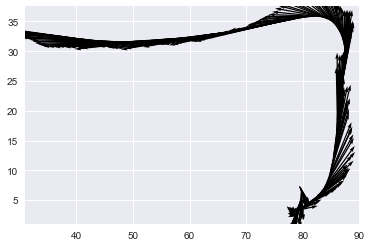

In [42]:
event =  df.loc[(df['EVENT_NUM'] == 9) &
             (df['SHOT_TIME'] - 3.5 < df['GAME_CLOCK']) &
             (df['SHOT_TIME'] + 7 > df['GAME_CLOCK'])]

x = event.iloc[::1]['PLAYER1_XLOC'].values
y = event.iloc[::1]['PLAYER1_YLOC'].values
u = event.iloc[::1]['PLAYER1_XVEL'].values
v = event.iloc[::1]['PLAYER1_YVEL'].values
plt.figure()
ax = plt.gca()
ax.quiver(x, y, u, v, angles = 'xy', scale_units='xy', scale = 1)
plt.draw()